# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [ ]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [ ]:
df = pd.read_csv('/content/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
22462,31250,76202,"New Delhi, India",03-04-2020,With the #coronavirus outbreak continuing its ...,Negative
19970,28143,73095,Northern CA,26-03-2020,Shame on u #FallingPrices 4 selling these #N95...,Negative
10159,16125,61077,Brussels/Beijing,21-03-2020,Nigeria s foreign exchange reserves have falle...,Extremely Negative
19371,27379,72331,"Exeter, UK",26-03-2020,@PMOIndia Onion/Tomato/Potato current price at...,Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [ ]:
df['Sentiment'].unique()

array(['Positive', 'Extremely Negative', 'Negative', 'Extremely Positive'],
      dtype=object)

In [ ]:
df['Sentiment'] = np.where(df['Sentiment'] == 'Positive', 1, df['Sentiment'])
df['Sentiment'] = np.where(df['Sentiment'] == 'Extremely Positive', 1, df['Sentiment'])
df['Sentiment'] = np.where(df['Sentiment'] == 'Negative', 0, df['Sentiment'])
df['Sentiment'] = np.where(df['Sentiment'] == 'Extremely Negative', 0, df['Sentiment'])
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
26519,36295,81247,"Lagos, Nigeria",07-04-2020,Government of Guinea announces it will cover w...,1
11059,17221,62173,Brentford,21-03-2020,This is too much!!! No fizzy san PelegrÃÂ­no ...,0
14200,21045,65997,New Zealand,23-03-2020,MIA chief predicts prices will inevitably rise...,0
3146,7606,52558,NaN,18-03-2020,Seeing people perfectly healthy and capable of...,1


Сбалансированы ли классы?

In [ ]:
df['Sentiment'].value_counts()

Sentiment
1    18046
0    15398
Name: count, dtype: int64

Классы несбалансированы, так как значений "1" на 3000 больше, чем значений "0".

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [ ]:
pd.isna(df).sum()

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [ ]:
df['Location'].fillna('Unknown', inplace=True)
pd.isna(df).sum()

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [ ]:
from sklearn.model_selection import train_test_split

np.random.seed(250)
train, test = train_test_split(df, test_size = 0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [ ]:
D = {}
line = ''
for line in train['OriginalTweet']:
  line = line.lower()
  line = line.split()
  for j in line:
    if j in D.keys():
      D[j] += 1
    else:
      D[j] = 1
print(D)

{'why': 654, 'we': 3787, 'still': 763, 'want': 487, 'to': 23373, 'buy': 748, 'so': 1837, 'much': 482, 'stuff': 106, 'during': 1908, 'quarantine': 154, 'https://t.co/1m881cwfuv': 1, '#shopping': 121, '#covid_19': 1660, '#online': 40, 'with': 4063, 'driving': 77, 'even': 682, 'more': 2008, 'usage': 22, 'a': 11737, 'strong': 93, 'strategy': 33, 'is': 7383, 'critical': 156, 'now': 1349, 'then': 435, 'ever': 179, 'luckily': 8, 'and': 14684, 'april': 163, '16': 36, 'webinar': 65, 'will': 2726, 'dive': 10, 'into': 666, 'growing': 84, 'app': 52, 'awareness': 32, 'targeting': 9, 'high': 408, 'lifetime': 4, 'value': 79, 'users': 19, '@canon_india': 16, 'i': 5340, 'am': 424, 'very': 418, 'happy..': 1, 'great': 409, 'job': 242, 'by': 2236, '#canonforcommunity': 5, 'https://t.co/z0intks34x': 1, 'the': 26815, 'u.s': 8, 'national': 123, 'debt': 68, 'likely': 170, 'exceed': 14, '$30': 7, 'trillion': 21, 'after': 886, 'unprecedented': 89, 'borrowing': 5, 'trump': 228, 'administration': 38, 'mnuchinã\x8

Какой размер словаря получился?

In [ ]:
len(D)

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [ ]:
words_sorted = sorted(D, key=D.get)
words_sorted_1 = words_sorted[len(words_sorted):len(words_sorted)-11:-1]
for i in words_sorted_1:
  print(i, D.get(str(i)))

the 26815
to 23373
and 14684
of 13012
a 11737
in 11198
for 8566
#coronavirus 8223
is 7383
are 7050


Данные токены находятся в топе, так как они состоят из предлогов, союзов и вспомогательных глаголов, которые довольно часто встречаются в текстах. Также в этот топ попал хештег про короновирус, что тоже логично, так как тема постов связана именно с ним.

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [ ]:
import nltk
nltk.download("stopwords", quiet=True)
from nltk.corpus import stopwords

stop_words = stopwords.words("english")
for i in stop_words:
  if i in D.keys():
    del D[str(i)]

In [ ]:
words_sorted_v2 = sorted(D, key=D.get)
words_sorted_v2_1 = words_sorted_v2[len(words_sorted_v2):len(words_sorted_v2)-11:-1]
for i in words_sorted_v2_1:
  print(i, D.get(str(i)))

#coronavirus 8223
prices 3891
food 3820
grocery 3469
supermarket 3288
people 3175
covid-19 3173
store 3155
#covid19 2471
&amp; 2314


После того, как мы убрали стоп-слова, самыми часто встречающимися стали слова, связаннные с людьми, местами их скопления (магазины различные). Также наиболее важные для людей проблемы (цены и продукты) тоже заняли высокие места. Ну и название эпидемии тоже находится в топе по частоте встречаемости.

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [ ]:
words_sorted_v2_2 = words_sorted_v2[0:20]
for i in words_sorted_v2_2:
  print(i, D.get(str(i)))

https://t.co/1m881cwfuv 1
happy.. 1
https://t.co/z0intks34x 1
mnuchinãâs 1
brink. 1
https://t.co/jmobv8z0u0 1
university's 1
teaching.) 1
@catholicpres 1
@catholicuniv 1
https://t.co/evqby035wf 1
https://t.co/riqrhxxeim 1
@@ballardspahrll 1
#aca 1
easier...take 1
ãânecessaryãâ 1
https://t.co/0fmsmlgepm 1
husted: 1
irishman 1
#happystpatricksday! 1


Данные слова наименее встречаемы из-за своей спецефичности. Среди них содержатся какие-то ссылки на сайты и аккаунты, а также просто редковстречающиеся слова.


Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [ ]:
from nltk.tokenize import TweetTokenizer

D_1 = {}
tw = TweetTokenizer()
for line in train['OriginalTweet']:
  line = line.lower()
  line = tw.tokenize(line)
  for j in line:
    if j in D_1.keys():
      D_1[j] += 1
    else:
      D_1[j] = 1
print(D_1)

{'why': 718, 'we': 3879, 'still': 788, 'want': 500, 'to': 23478, 'buy': 808, 'so': 1929, 'much': 514, 'stuff': 142, 'during': 1913, 'quarantine': 209, 'https://t.co/1m881cwfuv': 1, '#shopping': 121, '#covid_19': 1734, '#online': 41, 'with': 4114, 'driving': 80, 'even': 691, 'more': 2223, 'usage': 25, 'a': 11891, 'strong': 136, 'strategy': 43, 'is': 7464, 'critical': 162, 'now': 1827, 'then': 463, 'ever': 228, 'luckily': 13, 'and': 14825, 'april': 188, '16': 48, 'webinar': 71, 'will': 2746, 'dive': 11, 'into': 672, 'growing': 95, 'app': 66, 'awareness': 36, 'targeting': 10, 'high': 434, 'lifetime': 6, 'value': 93, 'users': 21, '@canon_india': 16, 'i': 5478, 'am': 464, 'very': 425, 'happy': 108, '..': 404, 'great': 431, 'job': 281, 'by': 2255, '#canonforcommunity': 5, 'https://t.co/z0intks34x': 1, 'the': 26993, 'u': 409, '.': 24118, 's': 3061, 'national': 124, 'debt': 89, 'likely': 172, 'exceed': 14, '$': 863, '30': 138, 'trillion': 23, 'after': 909, 'unprecedented': 90, 'borrowing': 5, 

In [ ]:
words_sorted_v3 = sorted(D_1, key=D_1.get)
words_sorted_v3_1 = words_sorted_v3[len(words_sorted_v3):len(words_sorted_v3)-11:-1]
for i in words_sorted_v3_1:
  print(i, D_1.get(str(i)))

the 26993
. 24118
to 23478
, 17571
and 14825
of 13044
a 11891
in 11348
? 9524
#coronavirus 8808


В полученном словаре наиболее популярными токенами являются стоп-слова и знаки пунктуации. Стоп-слова мы ещё не удаляли. Пунктуация находится в топе, так как данный токенайзер сохраняет смайлики, и одиночные знаки препинания под них тоже попадают.

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [ ]:
from string import punctuation

noise = stopwords.words("english") + list(punctuation)
for i in noise:
  if i in D_1.keys():
    del D_1[str(i)]

In [ ]:
words_sorted_v4 = sorted(D_1, key=D_1.get)
words_sorted_v4_1 = words_sorted_v4[len(words_sorted_v4):len(words_sorted_v4)-11:-1]
for i in words_sorted_v4_1:
  print(i, D_1.get(str(i)))

#coronavirus 8808
â 7415
 7311
19 7167
covid 6253
prices 4601
 4372
food 4367
store 3877
supermarket 3805


Теперь 7/10 токенов, попавших в топ 10 самых популярных это слова (включая число 19 и I). При этом остальные 3 токена представляют собой какие-то странные символы.

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [ ]:
D2 = {}

for i in D_1.keys():
  if len(i) != 1 or ord(i) < 128:
    D2[i] = D_1[i]

words_sorted_v5 = sorted(D2, key=D2.get)
words_sorted_v5_1 = words_sorted_v5[len(words_sorted_v5):len(words_sorted_v5)-11:-1]
for i in words_sorted_v5_1:
  print(i, D2.get(str(i)))

#coronavirus 8808
19 7167
covid 6253
prices 4601
food 4367
store 3877
supermarket 3805
grocery 3523
people 3463
#covid19 2589


In [ ]:
words_sorted_v5_2 = words_sorted_v5[0:20]
for i in words_sorted_v5_2:
  print(i, D2.get(str(i)))

https://t.co/1m881cwfuv 1
https://t.co/z0intks34x 1
mnuchinã 1
https://t.co/jmobv8z0u0 1
university's 1
@catholicpres 1
@catholicuniv 1
https://t.co/evqby035wf 1
https://t.co/riqrhxxeim 1
@ballardspahrll 1
#aca 1
https://t.co/0fmsmlgepm 1
irishman 1
#happystpatricksday 1
guiness 1
https://t.co/18v0pyhwb7 1
https://t.co/ls0g86i8pu 1
https://t.co/ofvkejff23 1
https://t.co/xoodgd2ulx 1
lifestyles 1


Заметным отличием стало то, что в первом словаре присутствовал токен "covid-19". Во втором же словаре он разделился на токены "covid" и "19", благодаря чему видно истинное количество употреблений каждого слова. При этом "19" употреблялось на 900 раз чаще, чем "covid".

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [ ]:
counter = 0
words_sorted_v6 = sorted(D2, key=D2.get)
words_sorted_v6_1 = words_sorted_v6[::-1]
for i in words_sorted_v6_1:
  if i[0] == '#':
    counter += 1
    print(i, D2.get(str(i)))
  if counter >= 10:
    break

#coronavirus 8808
#covid19 2589
#covid_19 1734
#covid2019 946
#toiletpaper 744
#covid 641
#socialdistancing 465
#coronacrisis 448
#pandemic 257
#coronaviruspandemic 249


7/10 хештегов содержат название пандемии в рзличных вариациях. Это объясняется тем, что большинство постов связаны с данной темой и содержат хештег с её названием. Остальные хештеги также связаны с пандемией, но просто не имеют однокоренных слов в своих названиях.

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [ ]:
counter = 0
for i in words_sorted_v6_1:
  if 'https://t.co' in i:
    counter += 1
    print(i, D2.get(str(i)))
  if counter >= 10:
    break

https://t.co/oxa7swtond 5
https://t.co/gp3eusapl8 4
https://t.co/oi39zsanq8 3
https://t.co/wuieefsnoj 3
https://t.co/bylqxrjmnt 3
https://t.co/aziqcdgrnn 3
https://t.co/g63rp042ho 3
https://t.co/catkegayoy 3
https://t.co/e2znxajpre 3
https://t.co/3gbbdpdjat 3


Популярность хештегов и ссылок на сайты нельзя сопоставить, так как упоминания ссылок исчисляются единицами. При этом какой-то особой пользы из этих данных нельзя извлечь.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [ ]:
def custom_tokenizer(text):

  text = text.lower()
  tw = TweetTokenizer()
  m = tw.tokenize(text)
  tokens = m.copy()
  for i in m:
    if i in stopwords.words("english") + list(punctuation) or (len(i) == 1 and ord(i) >= 128) or i[0:12] == 'https://t.co':
      tokens.remove(i)

  return tokens

In [ ]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")

cv = CountVectorizer(tokenizer = custom_tokenizer)

X = cv.fit_transform(train['OriginalTweet'])
print(len(cv.vocabulary_))

45308


Полученная длина словаря практически в 2 раза меньше результата, полученного в начале второго номера.

Посмотрим на какой-нибудь конкретный твитт:

In [ ]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [ ]:
text_as_vector = [train.iloc[ind]['OriginalTweet']]

A = cv.fit_transform(train['OriginalTweet'])

token_names = cv.get_feature_names_out(text_as_vector)
c = pd.DataFrame(A.toarray(), columns = token_names).iloc[[ind]]
c = c.drop(columns=c.columns[c.iloc[0] == 0])
c

,#coronavirusoutbreak,#covid2019,@skynews,brainless,ffs,food,france,lets,nice,one,panic,ppl,queueing,show
9023,1,1,1,1,1,1,1,1,1,1,1,1,1,1


К сожалению, не получилось определить самый важный и неважный токены, так как все они встретились лишь единожды. CountVectorizer не учитывает вхождения слов в другие тексты, поэтому каждое слово считается одновременно важным и неважным.

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(tokenizer = custom_tokenizer)

A_1 = tv.fit_transform(train['OriginalTweet'])
v = pd.DataFrame(A_1.toarray(), columns=tv.get_feature_names_out()).iloc[[ind]]
v = v.drop(columns=v.columns[v.iloc[0] == 0])
v

,#coronavirusoutbreak,#covid2019,@skynews,brainless,ffs,food,france,lets,nice,one,panic,ppl,queueing,show
9023,0.225843,0.168252,0.310426,0.386764,0.324474,0.113289,0.320473,0.301211,0.254273,0.163067,0.147595,0.255006,0.354346,0.244065


In [ ]:
# токен с самым большим весом
print(v.idxmax(axis = 1))
print(v.max(axis = 1))

9023    brainless
dtype: object
9023    0.386764
dtype: float64


In [ ]:
# токен с самым маленьким весом
print(v.idxmin(axis = 1))
print(v.min(axis = 1))

9023    food
dtype: object
9023    0.113289
dtype: float64


Самым важным токеном является слово "brainless", так как оно имеет наибольший вес среди представленных токенов. Наименее важным токеном является предлог "food", так как у него наименьший вес.

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [ ]:
train.reset_index(drop= True , inplace= True)
train[train['OriginalTweet'].apply(lambda x: 'gorgeous' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
572,39806,84758,Unknown,09-04-2020,My #blossomwatch today en route to the superma...,1


In [ ]:
ind_1 = 572

v_1 = pd.DataFrame(A_1.toarray(), columns=tv.get_feature_names_out()).loc[[ind_1]]
v_1 = v_1.drop(columns=v_1.columns[v_1.iloc[0] == 0])
v_1

,#blossomwatch,#ferlouginggraciously,#stayhomesavelives,briefly,couldnã,en,even,good,gorgeous,nice,resist,route,sample,supermarket,today,tulips,weather
572,0.317497,0.317497,0.177247,0.283854,0.232591,0.271437,0.139221,0.141775,0.317497,0.194779,0.271437,0.262627,0.260176,0.086889,0.134598,0.30508,0.226533


In [ ]:
train.iloc[ind_1]['OriginalTweet']

'My #blossomwatch today en route to the supermarket ! And couldnÃ\x82Â\x92t resist these gorgeous tulips. So nice to have good weather, even if we can only sample it briefly. #StayHomeSaveLives \r\r\n#ferlougingGraciously https://t.co/dbPfFvsxsf'

Положительным словом было выбрано прилагательное "gorgeous". В данном примере данным словом описываются тюльпаны, а токен получает один из самых больших весов. Данный токен напрямую влияет на окрас твитта, так как наверное никто не стал бы в негативном твитте хвалить тюльпаны.

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [ ]:
X_train = train.loc[:, train.columns != 'Sentiment']
y_train = train['Sentiment'].astype('int')

X_test = test.loc[:, test.columns != 'Sentiment']
y_test = test['Sentiment'].astype('int')

twitt_train_cv = cv.fit_transform(X_train['OriginalTweet'])
twitt_test_cv = cv.transform(X_test['OriginalTweet'])

twitt_train_tv = tv.fit_transform(X_train['OriginalTweet'])
twitt_test_tv = tv.transform(X_test['OriginalTweet'])

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression()

clf.fit(twitt_train_cv, y_train)

print(f"accuracy на train при CountVectorizer: {accuracy_score(y_train, clf.predict(twitt_train_cv))}")
print(f"accuracy на test при CountVectorizer: {accuracy_score(y_test, clf.predict(twitt_test_cv))}")

accuracy на train при CountVectorizer: 0.9844510892780863
accuracy на test при CountVectorizer: 0.8674506677297189


In [ ]:
clf.fit(twitt_train_tv, y_train)

print(f"accuracy на train при TfidfVectorizer: {accuracy_score(y_train, clf.predict(twitt_train_tv))}")
print(f"accuracy на test при TfidfVectorizer: {accuracy_score(y_test, clf.predict(twitt_test_tv))}")

accuracy на train при TfidfVectorizer: 0.9254592054677488
accuracy на test при TfidfVectorizer: 0.8533984452860275


CountVectorizer показал результат на трейне и тесте лучше, чем TfidfVectorizer. Можно заметить, что в случае CountVectorizer accuracy на обучающей выборке сильнее стремится к 1, в отличие от того же показателя но с TfidfVectorizer. При этом показатели на тестовой выборке различаются на 0.014. Это может говорить о переобучении первой модели.

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [ ]:
from nltk.stem.snowball import SnowballStemmer

def custom_stem_tokenizer(text):
  stemmer = SnowballStemmer("english")
  tw = TweetTokenizer()

  text = text.lower()
  text_tokens = tw.tokenize(text)
  tokens = text_tokens.copy()
  for i in text_tokens:
    if i in stopwords.words("english") + list(punctuation) or (len(i) == 1 and ord(i) >= 128) or i[0:12] == 'https://t.co':
      tokens.remove(i)

  tokens = [stemmer.stem(w) for w in tokens]
  return tokens

In [ ]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [ ]:
cv = CountVectorizer(tokenizer = custom_stem_tokenizer)
tv = TfidfVectorizer(tokenizer = custom_stem_tokenizer)

X_stemmed = cv.fit_transform(train['OriginalTweet'])
print(len(cv.vocabulary_))

36652


Размер словаря стал меньше. Это связано с тем, что раньше разные формы одного и того же слова записывались как отдельные токены. Теперь же разные формы одного слова обрезаются и записываются как один токен.

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [ ]:
twitt_train_cv = cv.fit_transform(X_train['OriginalTweet'])
twitt_test_cv = cv.transform(X_test['OriginalTweet'])

twitt_train_tv = tv.fit_transform(X_train['OriginalTweet'])
twitt_test_tv = tv.transform(X_test['OriginalTweet'])

clf.fit(twitt_train_cv, y_train)

print(f"accuracy на train при CountVectorizer: {accuracy_score(y_train, clf.predict(twitt_train_cv))}")
print(f"accuracy на test при CountVectorizer: {accuracy_score(y_test, clf.predict(twitt_test_cv))}")

clf.fit(twitt_train_tv, y_train)

print(f"accuracy на train при TfidfVectorizer: {accuracy_score(y_train, clf.predict(twitt_train_tv))}")
print(f"accuracy на test при TfidfVectorizer: {accuracy_score(y_test, clf.predict(twitt_test_tv))}")

accuracy на train при CountVectorizer: 0.9717642033319095
accuracy на test при CountVectorizer: 0.8674506677297189
accuracy на train при TfidfVectorizer: 0.9158906450234943
accuracy на test при TfidfVectorizer: 0.8560892963922663


В целом стемминг помог улучшить результат на тесте для модели с TfidfVectorizer. Доля верных ответов при CountVectorizer не изменилась на тесте. В случае с обучающими выборками, и там, и там результат снизился.

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=8000
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

36651


In [ ]:
# наверное ещё по заданию надо измерить долю верных ответов, но в задании этого нет. при этом строчка кода была, поэтому я нашёл._.

twitt_train_cv_df = cv_df.fit_transform(X_train['OriginalTweet'])
twitt_test_cv_df = cv_df.transform(X_test['OriginalTweet'])

clf.fit(twitt_train_cv_df, y_train)

print(f"accuracy на train: {accuracy_score(y_train, clf.predict(twitt_train_cv_df))}")
print(f"accuracy на test: {accuracy_score(y_test, clf.predict(twitt_test_cv_df))}")

accuracy на train: 0.9716360529688167
accuracy на test: 0.8681482957942994


Параметр max_df получился относительно небольшой в сравнении с теми количествами токенов, что мы видели в заданиях до этого. Доля верных ответов после использования данного параметра на обучающей выборке уменьшилась, а не тестовой - увеличилась.

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

3700


In [ ]:
twitt_train_cv_df = cv_df.fit_transform(X_train['OriginalTweet'])
twitt_test_cv_df = cv_df.transform(X_test['OriginalTweet'])

clf.fit(twitt_train_cv_df, y_train)

print(f"accuracy на train: {accuracy_score(y_train, clf.predict(twitt_train_cv_df))}")
print(f"accuracy на test: {accuracy_score(y_test, clf.predict(twitt_test_cv_df))}")

accuracy на train: 0.9284493806065783
accuracy на test: 0.8677496511859677


В сравнении с предыдущим результатом (с условием max_df) в этом случае доля верных ответов снизилась и на обучающей, и на тестовой выборках. При этом результат на тесте всё ещё лучше, чем когда мы вообще не использовали ограничение min_df.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)

train_delete = pd.DataFrame(twitt_train_cv_df.toarray(), columns = cv_df.get_feature_names_out())
test_delete = pd.DataFrame(twitt_test_cv_df.toarray(), columns = cv_df.get_feature_names_out())

twitt_train_cv_df_norm = scaler.fit_transform(train_delete)
twitt_test_cv_df_norm = scaler.transform(test_delete)

clf.fit(twitt_train_cv_df_norm, y_train)

print(f"accuracy на train: {accuracy_score(y_train, clf.predict(twitt_train_cv_df_norm))}")
print(f"accuracy на test: {accuracy_score(y_test, clf.predict(twitt_test_cv_df_norm))}")

accuracy на train: 0.9416915847928236
accuracy на test: 0.8447279250548136


<Axes: >

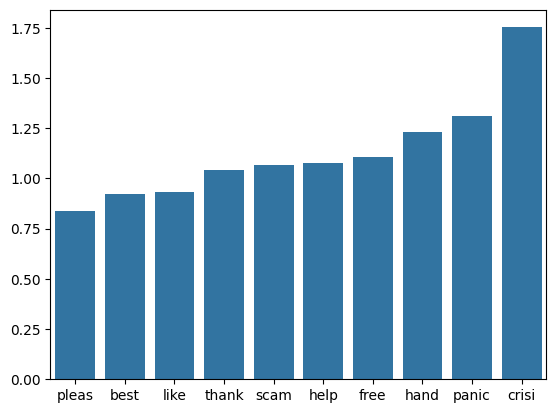

In [ ]:
# график

weights = abs(clf.coef_[0])
feature_names = cv_df.get_feature_names_out()
top_weights = np.sort(weights)[-10:]
top_weights_indexes = np.argsort(weights)[-10:]
top_weights_name = [feature_names[name] for name in top_weights_indexes]

sns.barplot(y=top_weights, x = top_weights_name)

Наибольшую важность имеет токен "crisi", который, скорее всего, является основной частью слов, связанных с кризисом, что говорит о важности в определении тона твитта. Следующий по частоте встречаемости является токен "panic", который чаще встречается в негативно окрашенных твиттах, поэтому он тоже имеет большую важность. Да и в целом все эти токены практически напрямую указывают на то, положительный или отрицательный это твитт.

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [ ]:
max(train['UserName'].value_counts())

1

In [ ]:
max(train['ScreenName'].value_counts())

1

Мы получили, что для обоих признаков все знавения уникальны. При таком раскладе данные признаки нельзя назвать хоть сколько-то полезными.

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

<Axes: xlabel='Sentiment'>

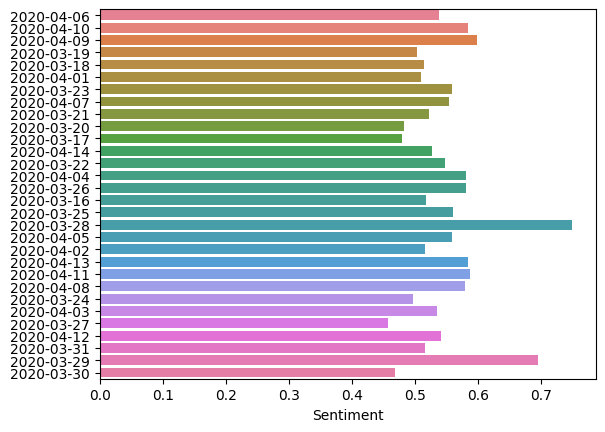

In [ ]:
from datetime import datetime

date_times = [datetime.strptime(date, '%d-%m-%Y') for date in train['TweetAt']]
sns.barplot(y=date_times, x = y_train, hue = date_times, ci = None)

Данный признак нельзя назвать полезным, несмотря на то, что гистограмма показывает, что в некоторые дни больше было положительных отзывов, а в некоторые - отрицательных. В количество положительных и отрицательных цветов равно, что о говорит о низкой полезности данного признака.

In [ ]:
# проверим полезность на всякий случай
train_2 = pd.get_dummies(train['TweetAt'], drop_first=False, dtype=int)
train_scaled = pd.DataFrame(data=twitt_train_cv_df_norm, columns=cv_df.get_feature_names_out())
train_2_1 = train_2.join(train_scaled)
train_2_1 = train_2_1.loc[:, train_2_1.columns != 'index']

test_2 = pd.get_dummies(test['TweetAt'], drop_first=False, dtype=int)
test_2.reset_index(drop = True, inplace = True)
test_2['index'] = test_2.index
test_scaled = pd.DataFrame(data=twitt_test_cv_df_norm, columns=cv_df.get_feature_names_out())
test_scaled['index'] = test_scaled.index
test_2_1 = test_2.merge(test_scaled, on='index')
test_2_1 = test_2_1.loc[:, test_2_1.columns != 'index']

clf.fit(train_2_1, y_train)
print(f"accuracy на train: {accuracy_score(y_train, clf.predict(train_2_1))}")
print(f"accuracy на test: {accuracy_score(y_test, clf.predict(test_2_1))}")

accuracy на train: 0.9434429730884237
accuracy на test: 0.8427347020131553


В итоге данный признак только ухудшил работу модели. (accuracy на тесте упала)

Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [ ]:
len(train['Location'].unique())

7949

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

<Axes: xlabel='count'>

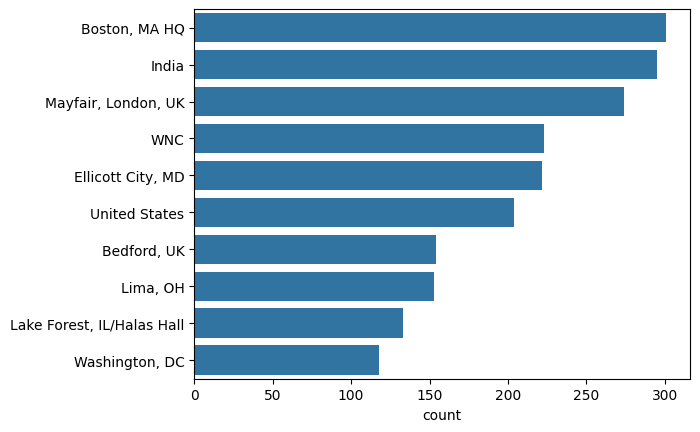

In [ ]:
locations_no_unknown= train[train['Location'] != 'Unknown']
locations_unique_no_unknown = locations_no_unknown['Location'].unique()
locations_num_no_unknown = locations_no_unknown['Location'].value_counts()

sns.barplot(y=locations_unique_no_unknown[:10], x = locations_num_no_unknown[:10], ci = None)

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [ ]:
def locations(text):
  text = tw.tokenize(text)
  token = text.copy()
  for i in text:
    if i in list(punctuation) or i == 'Unknown':
      pass
    else:
      return token[-1].strip()

In [ ]:
train_new = train.copy()
train_new.reset_index(inplace=True, drop=True)
train_new['WiderLocation'] = " "

test_new = test.copy()
test_new.reset_index(inplace=True, drop=True)
test_new['WiderLocation'] = " "

In [ ]:
for ind, row in train_new.iterrows():
  location = locations(train_new.loc[ind, 'Location'])
  train_new.loc[ind, 'WiderLocation'] = location

for ind, row in test_new.iterrows():
  location = locations(test_new.loc[ind, 'Location'])
  test_new.loc[ind, 'WiderLocation'] = location

len(train_new['WiderLocation'].unique())

2575

<Axes: ylabel='WiderLocation'>

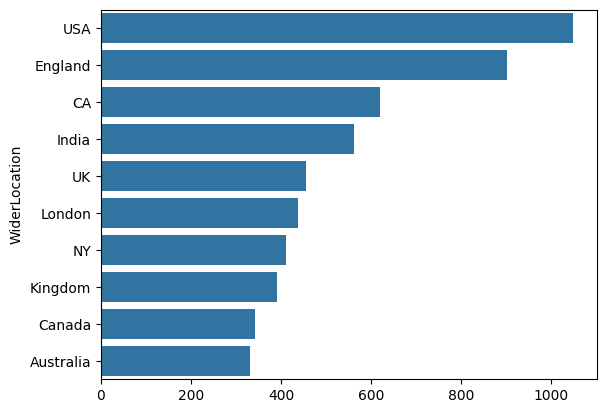

In [ ]:
train_new_data = train_new[train_new['WiderLocation'] != 0]

sns.barplot(x = train_new_data['WiderLocation'].value_counts(ascending=False).values[:10], y = train_new_data['WiderLocation'].value_counts(ascending=False).index[:10])

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [ ]:
num = train_new[['WiderLocation']].value_counts().to_dict()
location_single = []
for key, count in num.items():
  if count == 1:
    location_single.append(key[0:len(key)])
location_single = [item[0] for item in location_single]

for ind, row in train_new.iterrows():
  if train_new.loc[ind, 'WiderLocation'] in location_single or train_new.loc[ind, 'WiderLocation'] == 0:
    train_new.loc[ind, 'WiderLocation'] = '0'

num_test = test_new[['WiderLocation']].value_counts().to_dict()
location_single_test = []
for key, count in num_test.items():
  if count == 1:
    location_single_test.append(key[0:len(key)])
location_single_test = [item[0] for item in location_single_test]

for ind, row in test_new.iterrows():
  if test_new.loc[ind, 'WiderLocation'] in location_single_test or test_new.loc[ind, 'WiderLocation'] == 0:
    test_new.loc[ind, 'WiderLocation'] = '0'

In [ ]:
locations_survived = len(train_new['WiderLocation'].value_counts())
locations_survived

911

In [ ]:
from sklearn.preprocessing import OneHotEncoder

OHE = OneHotEncoder(handle_unknown='ignore', categories='auto', sparse=False)

train_wl_encoded = OHE.fit_transform(pd.DataFrame(train_new['WiderLocation']))
feature_names = OHE.get_feature_names_out(['WiderLocation'])
train_wl = pd.concat([train_new.drop(['WiderLocation'], axis=1), pd.DataFrame(train_wl_encoded, columns=feature_names)], axis=1)
train_wl_new = train_wl.drop(['WiderLocation_0', 'UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet', 'Sentiment'], axis = 1)

In [ ]:
test_wl_encoded = OHE.transform(pd.DataFrame(test_new['WiderLocation']))
feature_names_test = OHE.get_feature_names_out(['WiderLocation'])
test_wl = pd.concat([test_new.drop(['WiderLocation'], axis=1), pd.DataFrame(test_wl_encoded, columns=feature_names_test)], axis=1)
test_wl_new = test_wl.drop(['WiderLocation_0', 'UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet', 'Sentiment'], axis = 1)

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [ ]:
train_norm = pd.DataFrame(twitt_train_cv_df_norm)
test_norm = pd.DataFrame(twitt_test_cv_df_norm)

train_norm_locations = pd.concat([train_norm, train_wl_new], axis = 1, ignore_index = False)
test_norm_locations = pd.concat([test_norm, test_wl_new] ,axis = 1, ignore_index = False)

for col in train_norm_locations:
    train_norm_locations.rename(columns={col: str(col)}, inplace=True)

for col in test_norm_locations:
    test_norm_locations.rename(columns={col: str(col)}, inplace=True)

In [ ]:
clf.fit(train_norm_locations, y_train)
pred_train = clf.predict(train_norm_locations)
pred_test = clf.predict(test_norm_locations)

print(f'accuracy on train = {accuracy_score(y_train, pred_train)}')
print(f'accuracy on test = {accuracy_score(y_test, pred_test)}')

accuracy on train = 0.945279794959419
accuracy on test = 0.8437313135339845


В итоге имеем, что на обучающей выборке доля правильных ответов выросла, но при этом на тестовой выборке этот показатель снизился. Оба изменения произошли в в пределах сотых, что не является критичным результатом. Можно сделать вывод, что признак Location бесполезен.

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

In [ ]:
def custom_tokenizer(text):
  tw = TweetTokenizer()

  text = text.lower()
  text_tokens = tw.tokenize(text)
  tokens = text_tokens.copy()
  for i in text_tokens:
    if i in stopwords.words("english") + list(punctuation) or (len(i) == 1 and ord(i) >= 128) or i[0:12] == 'https://t.co':
      tokens.remove(i)

  return tokens

In [ ]:
def custom_stem_tokenizer(text):
  stemmer = SnowballStemmer("english")
  tw = TweetTokenizer()

  text = text.lower()
  text_tokens = tw.tokenize(text)
  tokens = text_tokens.copy()
  for i in text_tokens:
    if i in stopwords.words("english") + list(punctuation) or (len(i) == 1 and ord(i) >= 128) or i[0:12] == 'https://t.co':
      tokens.remove(i)

  tokens = [stemmer.stem(w) for w in tokens]
  return tokens

In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=8, max_df = 3500
                        ).fit(
                            train['OriginalTweet']
                            )
twitt_train_cv_df = cv_df.fit_transform(X_train['OriginalTweet'])
twitt_test_cv_df = cv_df.transform(X_test['OriginalTweet'])

In [ ]:
clf = LogisticRegression(max_iter = 250, random_state = 0)

clf.fit(twitt_train_cv_df, y_train)

print(f"accuracy на train: {accuracy_score(y_train, clf.predict(twitt_train_cv_df))}")
print(f"accuracy на test: {accuracy_score(y_test, clf.predict(twitt_test_cv_df))}")

accuracy на train: 0.9355830841520718
accuracy на test: 0.8700418576838749


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

bag = GradientBoostingClassifier(n_estimators=3000,
        max_depth=3,
        learning_rate=0.1,
        random_state=123,
    )
bag.fit(twitt_train_cv_df, y_train)

# TODO: рассчитайте MSE на тренировочной и тестовой выборках
print(f"accuracy on train set: {accuracy_score(y_train, bag.predict(twitt_train_cv_df)):.2f}")
print(f"accuracy on train set: {accuracy_score(y_test, bag.predict(twitt_test_cv_df)):.5f}")

accuracy on train set: 0.97
accuracy on train set: 0.88031


Неважно, какой ценой, но 0.88 есть, даже с переобучением.